In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
# from tensorflow.keras.layers.core import *
# from tensorflow.keras.layers.convolutional import *
from tensorflow.keras import backend as K
import tensorflow.compat.v1 as tf

# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 21 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.coarse = 27 # the number of coarse class
        self.feat_d = 210 # n(n-1)/2
        self.filters = 16
        self.data_dir = '..\\data\\JESTER\\'
C = Config()

# Building the model

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H,W],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l,joint_n,joint_d):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,joint_n*joint_d))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),joint_n*joint_d))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l,joint_n,joint_d)

    print("slow", diff_slow)
    print("fast", diff_fast)
    print("JCD", M)

    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    # 测试删去x_d_fast
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast]) # x = concatenate([x,x_d_slow,x_d_fast])
    print('concat', x.shape)
    x = block(x,filters*2)
    print('conv1', x.shape)
    x = MaxPool1D(2)(x)
    print('pool1', x.shape)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    print('conv2', x.shape)
    x = MaxPool1D(2)(x)
    print('pool2', x.shape)    
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    print('conv3', x.shape)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [5]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    print('pool', x.shape)    

    x = d1D(x,128)
    print('dense1', x.shape)    

    x = Dropout(0.5)(x)
    x = d1D(x,128)
    print('dense2', x.shape)    

    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    print('dense3', x.shape)    

    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.coarse,C.filters)

slow Tensor("reshape/Identity:0", shape=(None, 32, 42), dtype=float32)
fast Tensor("reshape_1/Identity:0", shape=(None, 16, 42), dtype=float32)
JCD Tensor("input_1:0", shape=(None, 32, 210), dtype=float32)
concat (None, 16, 48)
conv1 (None, 16, 32)
pool1 (None, 8, 32)
conv2 (None, 8, 64)
pool2 (None, 4, 64)
conv3 (None, 4, 128)
pool (None, 128)
dense1 (None, 128)
dense2 (None, 128)
dense3 (None, 27)


In [7]:
DD_Net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  [(None, 32, 210)]    0                                            
__________________________________________________________________________________________________
P (InputLayer)                  [(None, 32, 21, 2)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 4, 128)       117184      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 128)          0           model[1][0]                

## load data

In [8]:
# 切换成无空帧数据
Train = pickle.load(open(C.data_dir+"train_noempty.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"valid_noempty.pkl", "rb"))

## Without frame_sampling train

In [9]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,C.joint_n,C.joint_d])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range_2d(p)
    
    label = np.zeros(C.coarse)
    label[Train['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

100%|███████████████████████████████████████████████████████████████████████████████| 680/680 [00:05<00:00, 121.50it/s]


In [10]:
print(X_0.shape, X_1.shape, Y.shape)

(680, 32, 210) (680, 32, 21, 2) (680, 27)


In [11]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,C.joint_n,C.joint_d])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range_2d(p)
    
    label = np.zeros(C.coarse)
    label[Test['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 142.90it/s]


In [12]:
print(X_test_0.shape, X_test_1.shape, Y_test.shape)

(139, 32, 210) (139, 32, 21, 2) (139, 27)


In [ ]:
import tensorflow.keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])
lrScheduler = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 680 samples, validate on 139 samples
Epoch 1/600
680/680 [==============================] - 9s 14ms/sample - loss: 2.5433 - accuracy: 0.2809 - val_loss: 2.8349 - val_accuracy: 0.1942
Epoch 2/600
680/680 [==============================] - 0s 687us/sample - loss: 2.5063 - accuracy: 0.2794 - val_loss: 2.8489 - val_accuracy: 0.1727
Epoch 3/600
680/680 [==============================] - 1s 754us/sample - loss: 2.4948 - accuracy: 0.2853 - val_loss: 2.8657 - val_accuracy: 0.1655
Epoch 4/600
680/680 [==============================] - 0s 662us/sample - loss: 2.4997 - accuracy: 0.2794 - val_loss: 2.8918 - val_accuracy: 0.1871
Epoch 5/600
680/680 [==============================] - 0s 714us/sample - loss: 2.4763 - accuracy: 0.2809 - val_loss: 2.9031 - val_accuracy: 0.1799
Epoch 6/600
680/680 [==============================] - 0s 703us/sample - loss: 2.4807 - accuracy: 0.2882 - val_loss: 2.9019 - val_accuracy: 0.1942
Epoch 7/600
680/680 [==============================] - 0s 632us/sample - 

680/680 [==============================] - 1s 740us/sample - loss: 1.8683 - accuracy: 0.4206 - val_loss: 3.2217 - val_accuracy: 0.1871
Epoch 57/600
680/680 [==============================] - 0s 730us/sample - loss: 1.7886 - accuracy: 0.4647 - val_loss: 3.2438 - val_accuracy: 0.1871
Epoch 58/600
680/680 [==============================] - 1s 817us/sample - loss: 1.9085 - accuracy: 0.4309 - val_loss: 3.2912 - val_accuracy: 0.1942
Epoch 59/600
680/680 [==============================] - 0s 707us/sample - loss: 1.7768 - accuracy: 0.4632 - val_loss: 3.3126 - val_accuracy: 0.1871
Epoch 60/600
680/680 [==============================] - 1s 762us/sample - loss: 1.7490 - accuracy: 0.4882 - val_loss: 3.2873 - val_accuracy: 0.1799
Epoch 61/600
680/680 [==============================] - 0s 682us/sample - loss: 1.8018 - accuracy: 0.4588 - val_loss: 3.2779 - val_accuracy: 0.1799
Epoch 62/600
680/680 [==============================] - 0s 666us/sample - loss: 1.7562 - accuracy: 0.4853 - val_loss: 3.2648 

Epoch 112/600
680/680 [==============================] - 1s 745us/sample - loss: 1.1491 - accuracy: 0.6691 - val_loss: 3.5318 - val_accuracy: 0.1727
Epoch 113/600
680/680 [==============================] - 1s 865us/sample - loss: 1.1296 - accuracy: 0.6735 - val_loss: 3.5073 - val_accuracy: 0.1727
Epoch 114/600
680/680 [==============================] - 1s 877us/sample - loss: 1.1965 - accuracy: 0.6397 - val_loss: 3.4707 - val_accuracy: 0.1942
Epoch 115/600
680/680 [==============================] - 1s 842us/sample - loss: 1.1248 - accuracy: 0.6426 - val_loss: 3.4504 - val_accuracy: 0.1871
Epoch 116/600
680/680 [==============================] - 1s 817us/sample - loss: 1.0578 - accuracy: 0.6691 - val_loss: 3.4344 - val_accuracy: 0.2014
Epoch 117/600
680/680 [==============================] - 1s 800us/sample - loss: 1.1291 - accuracy: 0.6647 - val_loss: 3.4344 - val_accuracy: 0.1942
Epoch 118/600
680/680 [==============================] - 1s 810us/sample - loss: 1.1218 - accuracy: 0.6588

680/680 [==============================] - 1s 1ms/sample - loss: 0.8391 - accuracy: 0.7647 - val_loss: 3.5047 - val_accuracy: 0.1799
Epoch 168/600
680/680 [==============================] - 1s 1ms/sample - loss: 0.8569 - accuracy: 0.7456 - val_loss: 3.5026 - val_accuracy: 0.1799
Epoch 169/600
680/680 [==============================] - 1s 1ms/sample - loss: 0.8029 - accuracy: 0.7721 - val_loss: 3.4997 - val_accuracy: 0.1799
Epoch 170/600
680/680 [==============================] - 1s 1ms/sample - loss: 0.8239 - accuracy: 0.7544 - val_loss: 3.4964 - val_accuracy: 0.1799
Epoch 171/600
680/680 [==============================] - 1s 1ms/sample - loss: 0.8467 - accuracy: 0.7500 - val_loss: 3.4938 - val_accuracy: 0.1871
Epoch 172/600
680/680 [==============================] - 1s 1ms/sample - loss: 0.8029 - accuracy: 0.7676 - val_loss: 3.4906 - val_accuracy: 0.1799
Epoch 173/600
680/680 [==============================] - 1s 965us/sample - loss: 0.7710 - accuracy: 0.7691 - val_loss: 3.4872 - val_

680/680 [==============================] - 1s 977us/sample - loss: 0.8760 - accuracy: 0.7574 - val_loss: 3.4176 - val_accuracy: 0.2086
Epoch 223/600
680/680 [==============================] - 1s 1ms/sample - loss: 0.8145 - accuracy: 0.7662 - val_loss: 3.4170 - val_accuracy: 0.2086
Epoch 224/600
680/680 [==============================] - 1s 967us/sample - loss: 0.7689 - accuracy: 0.7676 - val_loss: 3.4162 - val_accuracy: 0.2086
Epoch 225/600
680/680 [==============================] - 1s 859us/sample - loss: 0.8424 - accuracy: 0.7647 - val_loss: 3.4156 - val_accuracy: 0.2086
Epoch 226/600
680/680 [==============================] - 1s 911us/sample - loss: 0.7556 - accuracy: 0.7735 - val_loss: 3.4147 - val_accuracy: 0.2086
Epoch 227/600
680/680 [==============================] - 1s 937us/sample - loss: 0.8326 - accuracy: 0.7441 - val_loss: 3.4141 - val_accuracy: 0.2086
Epoch 228/600
680/680 [==============================] - 1s 830us/sample - loss: 0.7869 - accuracy: 0.7897 - val_loss: 3.4

680/680 [==============================] - 1s 886us/sample - loss: 0.8020 - accuracy: 0.7721 - val_loss: 3.3820 - val_accuracy: 0.2230
Epoch 278/600
680/680 [==============================] - 1s 796us/sample - loss: 0.8265 - accuracy: 0.7632 - val_loss: 3.3817 - val_accuracy: 0.2230
Epoch 279/600
680/680 [==============================] - 1s 831us/sample - loss: 0.8033 - accuracy: 0.7794 - val_loss: 3.3812 - val_accuracy: 0.2230
Epoch 280/600
680/680 [==============================] - 1s 737us/sample - loss: 0.8184 - accuracy: 0.7750 - val_loss: 3.3810 - val_accuracy: 0.2230
Epoch 281/600
680/680 [==============================] - 1s 818us/sample - loss: 0.8178 - accuracy: 0.7603 - val_loss: 3.3807 - val_accuracy: 0.2230
Epoch 282/600
680/680 [==============================] - 1s 806us/sample - loss: 0.7854 - accuracy: 0.7588 - val_loss: 3.3803 - val_accuracy: 0.2230
Epoch 283/600
680/680 [==============================] - 1s 804us/sample - loss: 0.7410 - accuracy: 0.7956 - val_loss: 3

680/680 [==============================] - 1s 968us/sample - loss: 0.8706 - accuracy: 0.7706 - val_loss: 3.3750 - val_accuracy: 0.2230
Epoch 333/600
680/680 [==============================] - 1s 947us/sample - loss: 0.8334 - accuracy: 0.7412 - val_loss: 3.3750 - val_accuracy: 0.2230
Epoch 334/600
680/680 [==============================] - 1s 961us/sample - loss: 0.8494 - accuracy: 0.7485 - val_loss: 3.3748 - val_accuracy: 0.2230
Epoch 335/600
680/680 [==============================] - 1s 903us/sample - loss: 0.8133 - accuracy: 0.7515 - val_loss: 3.3749 - val_accuracy: 0.2230
Epoch 336/600
680/680 [==============================] - 1s 928us/sample - loss: 0.8079 - accuracy: 0.7809 - val_loss: 3.3750 - val_accuracy: 0.2230
Epoch 337/600
680/680 [==============================] - 1s 839us/sample - loss: 0.8497 - accuracy: 0.7574 - val_loss: 3.3751 - val_accuracy: 0.2230
Epoch 338/600
680/680 [==============================] - 1s 894us/sample - loss: 0.8165 - accuracy: 0.7706 - val_loss: 3

680/680 [==============================] - 1s 888us/sample - loss: 0.7792 - accuracy: 0.7794 - val_loss: 3.3756 - val_accuracy: 0.2230
Epoch 388/600
680/680 [==============================] - 1s 1ms/sample - loss: 0.7648 - accuracy: 0.7706 - val_loss: 3.3757 - val_accuracy: 0.2230
Epoch 389/600
680/680 [==============================] - 1s 967us/sample - loss: 0.8145 - accuracy: 0.7706 - val_loss: 3.3758 - val_accuracy: 0.2230
Epoch 390/600
680/680 [==============================] - 1s 929us/sample - loss: 0.7538 - accuracy: 0.7838 - val_loss: 3.3761 - val_accuracy: 0.2230
Epoch 391/600
680/680 [==============================] - 1s 923us/sample - loss: 0.8186 - accuracy: 0.7500 - val_loss: 3.3762 - val_accuracy: 0.2230
Epoch 392/600
680/680 [==============================] - 1s 969us/sample - loss: 0.8134 - accuracy: 0.7735 - val_loss: 3.3761 - val_accuracy: 0.2230
Epoch 393/600
680/680 [==============================] - 1s 925us/sample - loss: 0.7954 - accuracy: 0.7750 - val_loss: 3.3

680/680 [==============================] - 1s 832us/sample - loss: 0.8127 - accuracy: 0.7588 - val_loss: 3.3841 - val_accuracy: 0.2230
Epoch 443/600
680/680 [==============================] - 1s 901us/sample - loss: 0.7812 - accuracy: 0.7706 - val_loss: 3.3843 - val_accuracy: 0.2230
Epoch 444/600
680/680 [==============================] - 1s 880us/sample - loss: 0.8339 - accuracy: 0.7588 - val_loss: 3.3846 - val_accuracy: 0.2230
Epoch 445/600
680/680 [==============================] - 1s 940us/sample - loss: 0.8846 - accuracy: 0.7529 - val_loss: 3.3847 - val_accuracy: 0.2230
Epoch 446/600
680/680 [==============================] - 1s 940us/sample - loss: 0.8275 - accuracy: 0.7412 - val_loss: 3.3851 - val_accuracy: 0.2230
Epoch 447/600
680/680 [==============================] - 1s 955us/sample - loss: 0.7599 - accuracy: 0.7853 - val_loss: 3.3852 - val_accuracy: 0.2230
Epoch 448/600
680/680 [==============================] - 1s 818us/sample - loss: 0.7943 - accuracy: 0.7662 - val_loss: 3

Epoch 497/600
680/680 [==============================] - 1s 911us/sample - loss: 0.8073 - accuracy: 0.7706 - val_loss: 3.3923 - val_accuracy: 0.2230
Epoch 498/600
680/680 [==============================] - 1s 883us/sample - loss: 0.8521 - accuracy: 0.7706 - val_loss: 3.3921 - val_accuracy: 0.2230
Epoch 499/600
680/680 [==============================] - 1s 1ms/sample - loss: 0.7788 - accuracy: 0.7706 - val_loss: 3.3921 - val_accuracy: 0.2230
Epoch 500/600
680/680 [==============================] - 1s 853us/sample - loss: 0.8356 - accuracy: 0.7544 - val_loss: 3.3921 - val_accuracy: 0.2230
Epoch 501/600
680/680 [==============================] - 1s 1ms/sample - loss: 0.8292 - accuracy: 0.7603 - val_loss: 3.3920 - val_accuracy: 0.2230
Epoch 502/600
680/680 [==============================] - 1s 1ms/sample - loss: 0.8006 - accuracy: 0.7706 - val_loss: 3.3919 - val_accuracy: 0.2230
Epoch 503/600
680/680 [==============================] - 1s 1ms/sample - loss: 0.8493 - accuracy: 0.7382 - val_l

680/680 [==============================] - 1s 807us/sample - loss: 0.8058 - accuracy: 0.7500 - val_loss: 3.3978 - val_accuracy: 0.2158
Epoch 553/600
680/680 [==============================] - 1s 892us/sample - loss: 0.7318 - accuracy: 0.7941 - val_loss: 3.3979 - val_accuracy: 0.2158
Epoch 554/600
680/680 [==============================] - 1s 781us/sample - loss: 0.8559 - accuracy: 0.7544 - val_loss: 3.3984 - val_accuracy: 0.2158
Epoch 555/600
680/680 [==============================] - 1s 832us/sample - loss: 0.7892 - accuracy: 0.7824 - val_loss: 3.3984 - val_accuracy: 0.2158
Epoch 556/600
680/680 [==============================] - 1s 869us/sample - loss: 0.7809 - accuracy: 0.7691 - val_loss: 3.3988 - val_accuracy: 0.2158
Epoch 557/600
680/680 [==============================] - 1s 928us/sample - loss: 0.7669 - accuracy: 0.7824 - val_loss: 3.3986 - val_accuracy: 0.2158
Epoch 558/600
680/680 [==============================] - 1s 808us/sample - loss: 0.7452 - accuracy: 0.8044 - val_loss: 3

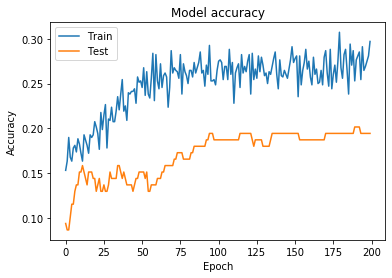

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
DD_Net.save_weights('weights/coarse_lite.h5')

## With frame_sampling

In [ ]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])

In [ ]:
epochs = 20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 

        label = np.zeros(C.clc_coarse)
        label[Train['coarse_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])
        p = sampling_frame(p,C)
        
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )



# Calculate time (excute it twice, the first time initialize takes extra times)

In [ ]:
import time
start_time = time.time()
y = DD_Net.predict([X_0,X_1])
time.time() - start_time

# Plot confusion matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = DD_Net.predict([X_test_0,X_test_1])
cnf_matrix = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
plt.figure(figsize=(10,10))
plt.imshow(cnf_matrix)
plt.show()